# Application of L1 Regularization.
- The point of this exercise is to show how L1 regularization is used.
- The L1 value will need to be computed and manually added to the loss function.
- A parametric experiment where the L1 lambda variable is varied will be conducted.

In [178]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# load the dataloader
from torch.utils.data import DataLoader, TensorDataset

# importing iris dataset
import seaborn as sns
iris_dataset = sns.load_dataset('iris')

from mpl_toolkits.mplot3d import Axes3D

### Transforming and Loading Data

In [ ]:
# converting from pandas dataframe to pytorch tensor
torched_iris_dataset= torch.tensor(iris_dataset[iris_dataset.columns[0:4]].values).float()

# numeric transformation - transforming species name to a number (0-2)
iris_labels = torch.zeros(len(torched_iris_dataset), dtype=torch.long)
iris_labels[iris_dataset.species=='versicolor'] = 1
iris_labels[iris_dataset.species=='virginica'] = 2

In [ ]:
# splitting iris dataset into training and testing
train_data, test_data, train_labels, test_labels = train_test_split(torched_iris_dataset, iris_labels, train_size= 0.8)

# converting to torch tensors, grouping data and labels
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# creating data loaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=12)
test_loader = DataLoader(test_data, shuffle=True, batch_size= test_data.tensors[0].shape[0])

### Function to Create Model

In [ ]:
def create_ANN_model():
    
    # model architecture
    ANN_model = nn.Sequential(
        nn.Linear(4, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 3)
    )

    # loss function
    loss_function = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANN_model.parameters(), lr=0.005)

    return ANN_model, loss_function, optimizer

#### Closer look at model architecture.
- The non-linear activation layers, such as the ReLU() layers, do not have any trainable parameters. These layers will be skipped when printing out the weights.
- To implement L1 Regularization, the model weights will need to be directly accessed.

In [ ]:
# examining model parameters in more detail
temp_model = create_ANN_model()[0]

# printing model
print(temp_model, '\n')

# printing model parameters
for i in temp_model.named_parameters():
    print(i[0], i[1].shape, i[1].numel())

---
### Function to Train Model
- Don't need to toggle model between `train` and `eval` modes because there is no batch normalization or dropout.
- This is where L1 Regularization will be applied.

In [ ]:
def batch_train_model(L1_lambda, number_of_epochs, ANN_iris, loss_function, optimizer):
    # initializing result arrays
    training_accuracy_ary = []
    testing_accuracy_ary = []
    losses_ary = []

    # counting number of weights in model
    num_weights = 0
    for param_name, weight in ANN_iris.named_parameters():
        if 'bias' not in param_name:
            num_weights += weight.numel()

    # loop over epochs
    for epoch_IDX in range(number_of_epochs):

        batch_accuracy = []
        batch_loss = []

        for batch, labels in train_loader:
        # forward pass and calculate loss
            y_hat = ANN_iris(batch)
            loss = loss_function(y_hat, labels)

            # L1 regularization
            L1_term = torch.tensor(0., requires_grad=True)

            # sum up all weights
            for param_name, weight in ANN_iris.named_parameters():
                if 'bias' not in param_name:
                    L1_term = L1_term + torch.sum(torch.abs(weight))

            # add L1 term to loss
            loss += L1_lambda * L1_term/num_weights

            # backpropagation (learning)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate accuracy for current batch
            batch_accuracy.append(100*torch.mean((torch.argmax(y_hat, axis=1) == labels).float()).item())

            # batch losses
            batch_loss.append(loss.item())

        # calculate overall training accuracy and loss
        training_accuracy_ary.append(np.mean(batch_accuracy))
        losses_ary.append(np.mean(batch_loss))

        # Cross Validation of Model
        X_data, y_labels = next(iter(test_loader)) # there is only one batch, so there's no need for a for loop
        predicted_testing_labels = torch.argmax(ANN_iris(X_data),axis=1)

        # calculate testing accuracy
        testing_accuracy_ary.append(100*torch.mean((predicted_testing_labels == y_labels).float()).item())

    return training_accuracy_ary, testing_accuracy_ary, losses_ary

#### Quick test of model and training.

In [ ]:
# model params
L1_lambdas = 0.001
num_epochs = 1000

# creating and training model
ANN_iris, loss_function, optimizer = create_ANN_model()
training_acc, test_acc, losses = batch_train_model(L1_lambdas, num_epochs, ANN_iris, loss_function, optimizer)

In [ ]:
# plotting results
fig, ax = plt.subplots(1,2, figsize = (15,5))

# losses plot
ax[0].plot(losses, 'k^-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title(f'Losses with L2 $\lambda$ = {L1_lambdas}')

# accuracy plot
ax[1].plot(training_acc, 'ro-')
ax[1].plot(test_acc, 'bs-')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Accuracy with L2 $\lambda$ = {L1_lambdas}')
ax[1].legend(['Training', 'Testing'])

In [ ]:
# smoothing function
def smooth(x, k):
    return np.convolve(x, np.ones(k)/k, mode= 'same')

# Parametric Experiment!

In [ ]:
# experiment params
L1_lambdas = np.linspace(0, 0.005, 10)
num_epochs = 350

# initializing output arrays
training_accuracy_results = np.zeros((num_epochs, len(L1_lambdas)))
test_accuracy_results = np.zeros((num_epochs, len(L1_lambdas)))

def L1_lambda_experiment(L1_lambdas, num_epochs):
    # loop over lambda values
    for lambda_IDX in range((len(L1_lambdas))):
        
        # create and train model
        ANN_iris, loss_function, optimizer = create_ANN_model()
        training_acc, test_acc, losses = batch_train_model(L1_lambdas[lambda_IDX], num_epochs, ANN_iris, loss_function, optimizer)

        # store results
        training_accuracy_results[:, lambda_IDX] = smooth(training_acc, 10)
        test_accuracy_results[:, lambda_IDX] = smooth(test_acc, 10)

    return training_accuracy_results, test_accuracy_results

# running experiment
training_accuracy_results, test_accuracy_results = L1_lambda_experiment(L1_lambdas, num_epochs)

In [ ]:
# plotting results
fig, ax = plt.subplots(1, 2, figsize = (22,8))

ax[0].plot(training_accuracy_results)
ax[0].set_title('Training Accuracy')

ax[1].plot(test_accuracy_results)
ax[1].set_title('Testing Accuracy')

# legend labels
legend_labels = [np.round(i,4) for i in L1_lambdas]

for i in range(2):
    ax[i].legend(legend_labels)
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,101])
    ax[i].grid()

plt.show()

#### Examining the results
- Will attempt identify if there is an L1 lambda value that improves the speed at which the model can learn.

In [ ]:
# limiting range of accuracy that is being plotted
epoch_range = [40, 150]

# averaging accuracies and plotting
plt.plot(L1_lambdas, np.mean(training_accuracy_results[epoch_range[0]:epoch_range[1],:], axis=0), 'bo-', label='Training')

plt.plot(L1_lambdas, np.mean(test_accuracy_results[epoch_range[0]:epoch_range[1], :], axis=0), 'rs-', label = 'Testing')

plt.xlabel('L1 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Analyzing the Results
- This experiment would have to be run numerous times to determine if there's an L1 value that will actually improve the model.

---
## Further Studies
- Will run parametric experiment multiple times to see if an emerging trend can be found for an effective L1 value.

In [101]:
# experiment params
number_of_runs = 10
L1_lambdas = np.linspace(0, 0.005, 10)
num_epochs = 350

# initializing output arrays for all runs
run_training_accuracy = np.zeros((num_epochs, len(L1_lambdas), number_of_runs))
run_test_accuracy = np.zeros((num_epochs, len(L1_lambdas), number_of_runs))

# loop over runs
for run_IDX in range(number_of_runs):
    training_accuracy_results, test_accuracy_results = L1_lambda_experiment(L1_lambdas, num_epochs)

    run_training_accuracy[:, :, run_IDX] = training_accuracy_results
    run_test_accuracy[:, :, run_IDX] = test_accuracy_results

In [181]:
# averaging results at a specific epoch range
epoch_range = [10, 125]
mean_training_acc = np.mean(run_training_accuracy[epoch_range[0]:epoch_range[1],:,:], axis = 0)
mean_test_acc = np.mean(run_test_accuracy[epoch_range[0]:epoch_range[1],:,:], axis = 0)

print(mean_training_acc.shape)
print(mean_training_acc)

# Average over all runs
average_training_acc = np.mean(mean_training_acc, axis=1)
average_test_acc = np.mean(mean_test_acc, axis=1)

(10, 10)
[[91.21014527 89.21376844 90.86086995 89.25579739 90.20289893 90.84855114
  90.79927567 90.13043509 91.70000038 90.5304351 ]
 [89.41086992 92.09058012 85.88188434 92.48333372 92.0637685  91.43260905
  89.71666697 91.79637716 90.87029014 89.74855106]
 [92.30000041 88.81449306 91.26956558 91.62173951 89.23478286 87.59130464
  90.3557974  91.05797137 87.7108698  87.97753646]
 [88.62391326 90.76159453 90.88985545 90.48695689 90.22101483 88.70797127
  85.7362322  89.75000038 91.30942071 89.60724662]
 [92.1405801  90.08550757 89.6992757  89.91594236 89.94130468 90.61159454
  90.44058006 89.63405834 90.58405832 88.88115977]
 [91.02826128 89.75652212 91.63985547 91.68333376 90.31739172 90.22681194
  91.02173948 91.86086992 90.8536236  91.03550764]
 [91.43405836 88.87971045 90.63985542 91.91231919 87.85072491 89.60652204
  89.69565249 91.52753661 88.73478289 90.550725  ]
 [91.89927568 90.14347864 90.36304382 91.25797136 91.44058012 90.10000032
  90.37029025 91.42681197 92.16739173 90.6

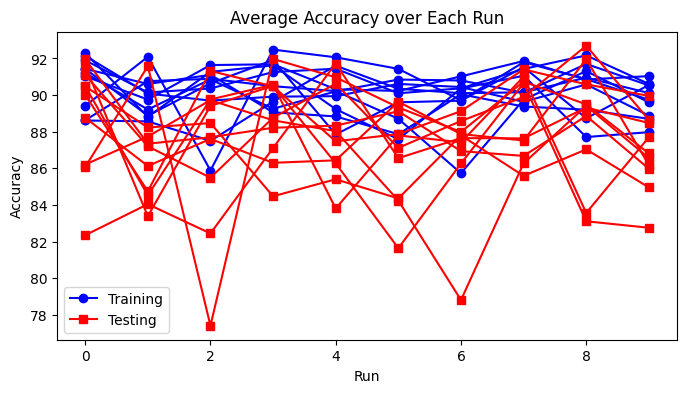

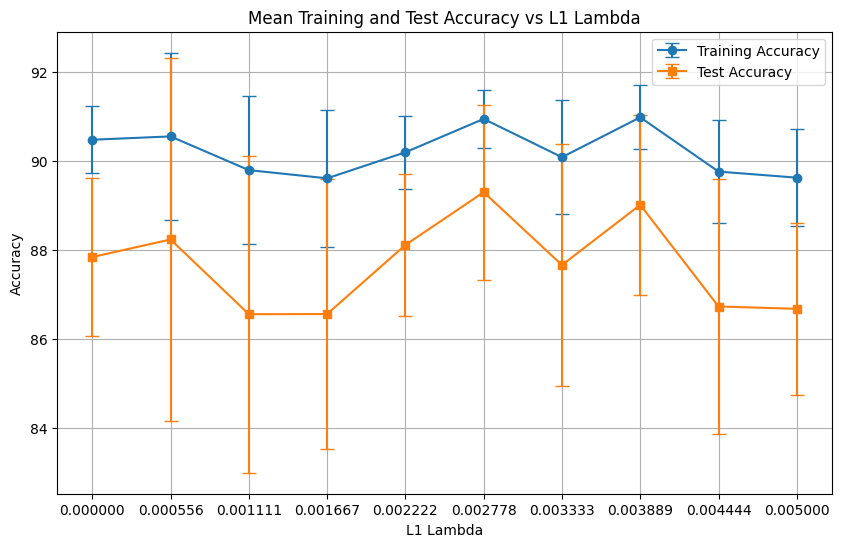

In [193]:
# Plotting
plt.figure(figsize=(8, 4))

# Plot all training accuracies with the same label
for i in range(len(L1_lambdas)):
    plt.plot(mean_training_acc[i, :], 'bo-', label='Training' if i == 0 else "")

# Plot all test accuracies with the same label
for i in range(len(L1_lambdas)):
    plt.plot(mean_test_acc[i, :], 'rs-', label='Testing' if i == 0 else "")

plt.title("Average Accuracy over Each Run")
plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculate standard deviation across runs for error bars
std_training_acc = np.std(mean_training_acc, axis=1)
std_test_acc = np.std(mean_test_acc, axis=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(L1_lambdas, average_training_acc, yerr=std_training_acc, fmt='-o', label='Training Accuracy', capsize=5)
plt.errorbar(L1_lambdas, average_test_acc, yerr=std_test_acc, fmt='-s', label='Test Accuracy', capsize=5)

plt.title('Mean Training and Test Accuracy vs L1 Lambda')
plt.xlabel('L1 Lambda')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(L1_lambdas)  # Set x-ticks to the L1 lambda values
plt.show()

### Looking at the Results:
- This accuracies are taken from the range of epochs where the model is still learning.
- The L1 lambda values that are associated with a higher accuracy do help with the model's learning speed.
- There would still need to be more testing and statistical analysis to see if there is a difference.
- Overall results - still inconclusive. There do appear to be some L1 values that are associated with a higher accuracy, but that can't be said for sure yet.